# Replacing Faces with Generated Images using the Diffusion Model
This Colab allows to take an input image, crops the face in the image, and generates a new face using a pre-trained diffusion model.

Once uploaded, a facial detection algorithm is used to locate the face in the image and crop it automatically. The cropped image is then fed into the pre-trained diffusion model, which generates a new face that tries to match the lighting, orientation, and pose of the original face. The generated face is then superimposed on the original image, creating a new image with a newly generated face.

In this work, we utilize a diffusion model trained on the CelebA aligned dataset. 

# Libraries installation



In [1]:
%%capture
!pip install face-recognition

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import face_recognition
import math
import pandas as pd
import sys

import tensorflow as tf
from tensorflow import keras
from keras import layers

import skimage
from skimage import color

from google.colab import files
import gdown
import re

## Constant configuration

In [3]:
FACE_SIZE = (64, 64)
FACE_LOCATION_MODEL = 'hog'  # cnn more accuracy, hog more performance

ROLL_START_ROTATION_TOLERANCE = 15

ROLL_ROTATION_TOLERANCE = 45
YAW_ROTATION_TOLERANCE = 50
PITCH_ROTATION_TOLERANCE = 45

IMAGE_MAX_DIMENSION = 1280

# Load Image
This section of the platform enables users to upload their desired images. For optimal results, we recommend uploading images with clear and well-aligned faces. Images with faces that are too inclined or rotated may result in less accurate face detection and cropping. Therefore, to ensure the highest quality output, we suggest using images that meet these criteria. 

In [4]:
def cast_image_to_float32(image):
  if image.dtype == np.uint8:
    image = image / 255
    image = image.astype('float32')
  return image

def cast_image_to_int(image):
  if image.dtype == np.float32:
    scale = 255.0 / (np.max(image) - np.min(image))
    img_normalized = (image -  np.min(image)) * scale
    image = img_normalized.astype(np.uint8)
  return image


def image_resize_keeping_aspect_ratio(image, width = None, height = None, inter = cv2.INTER_AREA):
  dim = None
  (h, w) = image.shape[:2]

  if width is None and height is None:
      return image

  if width is None:
      r = height / float(h)
      dim = (int(w * r), height)
  else:
      r = width / float(w)
      dim = (width, int(h * r))

  resized = cv2.resize(image, dim, interpolation = inter)

  return resized

def load_input_image():
  uploaded = files.upload()
  filename = next(iter(uploaded))

  img = cv2.imread(filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cast_image_to_float32(img)

  height, width, _ = img.shape

  if max(height, width) > IMAGE_MAX_DIMENSION:
    print('Resizing input image')
    if height >= width:
      img = image_resize_keeping_aspect_ratio(img, width=None, height= IMAGE_MAX_DIMENSION, inter=cv2.INTER_AREA)
    else:
      img = image_resize_keeping_aspect_ratio(img, width= IMAGE_MAX_DIMENSION, height=None, inter=cv2.INTER_AREA)

  return img

Saving 1200px-François_Clouet_-_Mary,_Queen_of_Scots_(1542-87)_-_Google_Art_Project.jpg to 1200px-François_Clouet_-_Mary,_Queen_of_Scots_(1542-87)_-_Google_Art_Project.jpg
Resizing input image


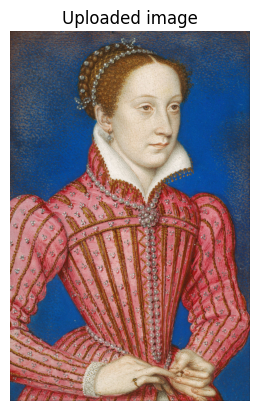

In [26]:
image = load_input_image()

plt.imshow(image)
plt.title('Uploaded image')
plt.axis('off')
plt.show()

# Load diffusion model and unet
This section is responsible for defining and loading the models used for face generation. Specifically, it loads the diffusion model and sets up the normalizer layer. Additionally, it loads a pre-trained U-Net as the embedding model.

## Models definition

In [6]:
### Network's Blocks

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

    
def ResidualBlock(depth):
    def apply(x):
        input_depth = x.shape[3]
        if input_depth == depth:
            residual = x
        else:
            residual = layers.Conv2D(depth, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            depth, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(depth, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(depth)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(depth)(x)
        return x

    return apply

#Get networks
def get_denoising_network(image_size, depths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(depths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for depth in depths[:-1]:
        x = DownBlock(depth, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(depths[-1])(x)

    for width in reversed(depths[:-1]): #errore width should be depth
        x = UpBlock(depth, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="denoising")


def get_Unet(image_size, depths, block_depth):
    input_images = keras.Input(shape=(image_size, image_size, 3))

    x = layers.Conv2D(depths[0], kernel_size=1)(input_images)

    skips = []
    for depth in depths[:-1]:
        x = DownBlock(depth, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(depths[-1])(x)

    for depth in reversed(depths[:-1]): 
        x = UpBlock(depth, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model(input_images, x, name="unet")


batch_size= 16
learning_rate= 0.0001

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
image_size = 64
embedding_dims = 64
embedding_max_frequency = 1000.0
depths = [48, 96, 192, 384]
block_depth = 2

class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth, batch_size):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_denoising_network(image_size, widths, block_depth)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    def load_weights(self, filename):
        self.network.load_weights(filename)

    def save_weights(self, filename):
        self.network.save_weights(filename)

    @property
    def metrics(self):
        return [self.noise_loss_tracker, 
                self.image_loss_tracker 
                ]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        network = self.network
        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        if num_images is None:
            num_images = 10
        step_size = 1.0 / diffusion_steps

        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=id_diffusion_steps
        )

        return {m.name: m.result() for m in self.metrics}  

Gradient Descent Model:
the image to modify is the "initial noise" of the reverse diffusion process.

In [7]:
class DescentModel(keras.Model):
    def __init__(self, reference_model, n, starting_noise = None):
        super().__init__()
        self.reference_model = reference_model
        self.n = n
        self.starting_noise = starting_noise
    
    def build(self, input_shape):
        zero_initializer = tf.keras.initializers.Zeros()
        if self.starting_noise is None:
            initializer = tf.keras.initializers.RandomNormal(mean=0.,stddev=1.)
        else:
            initializer = tf.keras.initializers.Constant(self.starting_noise)
        self._initial_noise = self.add_weight(name='initial_noise', shape=(self.n,)+input_shape[1:], initializer=initializer, trainable=True)

  
    def call(self, inputs):
        self.add_loss(.005 * tf.reduce_mean(self._initial_noise**2))
        generated_images = self.reference_model.reverse_diffusion(self._initial_noise, 10)
        #generated_images = self.reference_model.denormalize(generated_images)
        generated_images = self.reference_model.normalizer.mean + generated_images * self.reference_model.normalizer.variance**0.5
        return generated_images
    
    def compute_output_shape(self, input_shape):
        return (self.n,) + input_shape[1:]
 
def loss_function(ground_truth, predicted):
    return tf.reduce_mean(tf.math.abs(ground_truth - predicted))

def diffusion_descent(model,ground_truth,n,starting_noise=None, epochs=100):
    ground_truth = tf.expand_dims(ground_truth, 0)
    descent_model = DescentModel(model,n,starting_noise=starting_noise)
    descent_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss=loss_function
    )


    descent_model.fit(
        x=ground_truth,
        y=ground_truth,
        epochs=epochs
    )

    output = descent_model.predict(
        ground_truth
    )
    return output, descent_model._initial_noise 

Loading U-net for segmentation post-processing step

In [8]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)
    
    return act2

def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def U_Net(Image_Size):
    # Take the image size and shape
    input1 = layers.Input(Image_Size)
    
    skip1, encoder_1 = encoder(input1, 32)
    skip2, encoder_2 = encoder(encoder_1, 32*2)
    skip3, encoder_3 = encoder(encoder_2, 32*4)
    skip4, encoder_4 = encoder(encoder_3, 32*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 32*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 32*8)
    decoder_2 = decoder(decoder_1, skip3, 32*4)
    decoder_3 = decoder(decoder_2, skip2, 32*2)
    decoder_4 = decoder(decoder_3, skip1, 32)
    
    out = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = keras.models.Model(input1, out)
    return model


Super resolution model

In [9]:
class SelfAttention(layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.query_conv = layers.Conv2D(channels // 8, 1, padding='same')
        self.key_conv = layers.Conv2D(channels // 8, 1, padding='same')
        self.value_conv = layers.Conv2D(channels, 1, padding='same')
        self.gamma = self.add_weight('gamma', shape=[1], initializer='zeros')

    def call(self, x):
        batch_size, height, width, channels = x.shape
        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)

        query = layers.Reshape((height * width, self.channels // 8))(query)
        key = layers.Reshape((height * width, self.channels // 8))(key)
        attention = layers.dot([query, tf.keras.backend.permute_dimensions(key, (0, 2, 1))], axes=[2, 1])
        attention = layers.Activation('softmax')(attention)
        value = layers.Reshape((height * width, channels))(value)
        attention = layers.dot([attention, value], axes=[2, 1])
        attention = layers.Reshape((height, width, channels))(attention)
        x = self.gamma * attention + x

        return x

def resBlock(inputs, filters_size, kernel_size = 3):

    x = layers.Conv2D(filters=filters_size, kernel_size=kernel_size, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Conv2D(filters=filters_size, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, inputs])

    return x

def upsampling(inputs, filters_size, kernel_size = 3, factor=2):

    x = layers.Conv2D(filters=filters_size, kernel_size=kernel_size, padding='same')(inputs)
    x = layers.UpSampling2D(size=factor)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)

    return x

def build_superRes_model(input_shape = (64, 64, 3), filters_size = 64, num_res_block = 16):
    inputs = layers.Input(shape=input_shape)

    x = skip_connection = layers.Conv2D(filters=filters_size, kernel_size=9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_block):        
        x = resBlock(x, filters_size, kernel_size=3)
        x = SelfAttention(filters_size)(x) 

    x = layers.Conv2D(filters=filters_size, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, skip_connection])

    x = upsampling(x, filters_size, kernel_size = 3)
    x = upsampling(x, filters_size, kernel_size = 3)

    outputs = layers.Conv2D(filters=3, kernel_size=9, padding='same', activation='sigmoid')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model


## Models loading

In [10]:
# download the models weights and part of training data used to adapt the normalizer layer

diffusion_model_weights_link = 'https://drive.google.com/file/d/14RiXmAmsjdy29Ih6bUH4dC46B4U1J4Uq/view?usp=sharing'
unet_model_weights_link = 'https://drive.google.com/file/d/1HG9JSCPveds6nEYb7EnEPblpql15C0-S/view?usp=sharing'
samples_for_adapter_link = 'https://drive.google.com/file/d/1LK6IkFekW3_jxNrhhLJ3Af6J2IJiLSLI/view?usp=share_link'
segmentation_model_weights_link ='https://drive.google.com/file/d/102rVJNJES096izz1d2HlZpsW_teVK7jc/view?usp=share_link' 
superres_model_weights_link ='https://drive.google.com/file/d/1aFAhnvmBBGq-2OeqzxgzQO0Y9sHDYX6q/view?usp=share_link' 

In [11]:

# Define a regex pattern to match the file ID
pattern = r'/file/d/([-\w]+)'

file_names = {diffusion_model_weights_link: 'diffusion_model_weights.hdf5',
              unet_model_weights_link: 'unet_model_weights.hdf5',
              samples_for_adapter_link: 'samples_for_adapter.npy',
              segmentation_model_weights_link: 'segmentation_model_weights.h5',
              superres_model_weights_link: 'superres_model_weights.h5'
              }

for link in file_names.keys():

  # Find the file ID using regex search
  match = re.search(pattern, link)

  if match:
      file_id = match.group(1)
      print("File ID:", file_id)
      gdown.download(id=file_id, output=file_names[link], quiet=False)
      print(f'{file_names[link]} downloaded')
  else:
      print("No match found.")


File ID: 14RiXmAmsjdy29Ih6bUH4dC46B4U1J4Uq


Downloading...
From: https://drive.google.com/uc?id=14RiXmAmsjdy29Ih6bUH4dC46B4U1J4Uq
To: /content/diffusion_model_weights.hdf5
100%|██████████| 48.9M/48.9M [00:05<00:00, 8.92MB/s]


diffusion_model_weights.hdf5 downloaded
File ID: 1HG9JSCPveds6nEYb7EnEPblpql15C0-S


Downloading...
From: https://drive.google.com/uc?id=1HG9JSCPveds6nEYb7EnEPblpql15C0-S
To: /content/unet_model_weights.hdf5
100%|██████████| 38.5M/38.5M [00:00<00:00, 70.5MB/s]


unet_model_weights.hdf5 downloaded
File ID: 1LK6IkFekW3_jxNrhhLJ3Af6J2IJiLSLI


Downloading...
From: https://drive.google.com/uc?id=1LK6IkFekW3_jxNrhhLJ3Af6J2IJiLSLI
To: /content/samples_for_adapter.npy
100%|██████████| 50.3M/50.3M [00:00<00:00, 127MB/s]


samples_for_adapter.npy downloaded
File ID: 102rVJNJES096izz1d2HlZpsW_teVK7jc


Downloading...
From: https://drive.google.com/uc?id=102rVJNJES096izz1d2HlZpsW_teVK7jc
To: /content/segmentation_model_weights.h5
100%|██████████| 31.3M/31.3M [00:00<00:00, 46.1MB/s]


segmentation_model_weights.h5 downloaded
File ID: 1aFAhnvmBBGq-2OeqzxgzQO0Y9sHDYX6q


Downloading...
From: https://drive.google.com/uc?id=1aFAhnvmBBGq-2OeqzxgzQO0Y9sHDYX6q
To: /content/superres_model_weights.h5
100%|██████████| 22.7M/22.7M [00:00<00:00, 211MB/s]

superres_model_weights.h5 downloaded


In [12]:
diffusion_model = DiffusionModel(image_size, depths, block_depth, batch_size= batch_size)
diffusion_model.compile(optimizer=keras.optimizers.Adam(learning_rate= learning_rate),
                        loss=keras.losses.mean_absolute_error)
X_train = np.load(f"samples_for_adapter.npy")
diffusion_model.normalizer.adapt(X_train)
diffusion_model.load_weights(f"diffusion_model_weights.hdf5")
diffusion_model.trainable = False #IMPORTANT for gradient descent refinement


embedding_model = get_Unet(64,depths,block_depth)
embedding_model.load_weights(f"unet_model_weights.hdf5")


segmentation_model = U_Net((128, 128, 3))
segmentation_model.compile(optimizer="rmsprop", loss=None)
segmentation_model.load_weights(f"segmentation_model_weights.h5")
segmentation_model.trainable = False


superres_model = build_superRes_model(input_shape = (64, 64, 3), filters_size=128, num_res_block=16)
superres_model.compile(optimizer='adam', loss=None)
superres_model.trainable = False
superres_model.load_weights('superres_model_weights.h5')

## Define the reification function

In [13]:

def reification(image, reverse_step = 10, gradient_descent_refinement = False, gradient_descent_epochs = 50):
    image = cast_image_to_float32(image)
    
    input_exp = tf.expand_dims(image, 0)
    latent = embedding_model(input_exp)
    renorm_seeds = np.clip(latent, -2.5, 2.5)
    renorm_seeds = (renorm_seeds + 2.5) / 5.
    generated = diffusion_model.reverse_diffusion(latent, reverse_step)
    generated = diffusion_model.denormalize(generated)
    generated = generated[0].numpy()


    if gradient_descent_refinement: #gradient descent refinement
        print("Using Gradient Descent Refinement")
        error = np.mean((generated-image)**2)
        print(f"Initial error (mse): {error}")
        generated, latent = diffusion_descent(diffusion_model, image, 1, starting_noise = latent, epochs=gradient_descent_epochs)
        generated = generated[0]
        renorm_seeds = np.clip(latent,-2.5,2.5)
        renorm_seeds = (renorm_seeds+2.5)/5.
        error = np.mean((generated-image)**2)
        print(f"Error after Gradient Descent Refinement (mse): {error}")
    
    return renorm_seeds[0], generated

# Reification Pipeline
This section is the core of the Colab, where we implement the main functionality for face generation.

The first step is to locate the faces in the input image using the face-recognition library. Once the faces are located, we compute crop boxes around them to extract their region of interest.

Next, we use face-recognition to detect landmarks and compute the face orientations, namely yaw, pitch, and roll. We then check if these values are below a certain tolerance to ensure that the input image presents faces that are upright and properly oriented.

Finally, we use the pre-trained models to generate new faces and replace them in the original picture. This is done using the diffusion model and normalized seeds generated from the input image.

## Image manipulation utility functions

In [14]:
def rotate_image(mat, angle):
    height, width = mat.shape[:2] 
    image_center = (width/2, height/2) 
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_img = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))

    return rotated_img, rotation_mat


def rotate_image_points(points, rotation_matrix):
    rotated_points = []
    for point in points:
        rotated_point = np.dot(rotation_matrix, [point[0], point[1], 1]).astype(int)[:2]
        rotated_points.append((int(rotated_point[0]), int(rotated_point[1])))
    
    return rotated_points
  
def color_correction(source, target):
    target_size = (target.shape[1], target.shape[0])

    if source.shape[0] > target_size[0]:
      source = cv2.resize(source, target_size, interpolation=cv2.INTER_AREA)

    elif source.shape[0] < target_size[0]:
      source = cv2.resize(source, target_size, interpolation=cv2.INTER_CUBIC)


    source = cast_image_to_int(source)
    target = cast_image_to_int(target)

    lab_in = cv2.cvtColor(target, cv2.COLOR_RGB2LAB)
    lab_ref = cv2.cvtColor(source, cv2.COLOR_RGB2LAB)

    mean_in = np.mean(lab_in, axis=(0, 1), keepdims=True)
    mean_ref = np.mean(lab_ref, axis=(0, 1), keepdims=True)
    std_in = np.std(lab_in, axis=(0, 1), keepdims=True)
    std_ref = np.std(lab_ref, axis=(0, 1), keepdims=True)
    img_arr_out = (lab_in - mean_in) / std_in * std_ref + mean_ref
    img_arr_out[img_arr_out < 0] = 0
    img_arr_out[img_arr_out > 255] = 255

    img_arr_out = cv2.cvtColor(img_arr_out.astype("uint8"), cv2.COLOR_LAB2RGB)

    img_arr_out = cast_image_to_float32(img_arr_out)

    return img_arr_out



def alphaMerge(small_foreground, background, top, left):
    result = background.copy()

    fg_b, fg_g, fg_r, fg_a = cv2.split(small_foreground)
    label_rgb = cv2.merge([fg_b * fg_a, fg_g * fg_a, fg_r * fg_a])
   
    height, width = small_foreground.shape[0], small_foreground.shape[1]
    part_of_bg = result[top:top + height, left:left + width, :]

    bg_b, bg_g, bg_r = cv2.split(part_of_bg)
    part_of_bg = cv2.merge([bg_b * (1 - fg_a), bg_g * (1 - fg_a), bg_r * (1 - fg_a)])

    cv2.add(label_rgb, part_of_bg, part_of_bg)
    result[top:top + height, left:left + width, :] = part_of_bg

    return result

## Compute face Info

### Compute Face Crop Box

In [15]:
def compute_crop_box_center(landmarks):
  center_x = int((landmarks['left_eye'][3][0] + landmarks['right_eye'][-1][0]) / 2)
  center_y = int((landmarks['left_eye'][3][1] + landmarks['right_eye'][-1][1]) / 2)
  y_correction = int((landmarks['left_eyebrow'][4][1] + landmarks['right_eyebrow'][0][1]) / 2)
  center_y = int((center_y + y_correction) //2)

  return (center_x, center_y)


def get_box_size(landmarks, center):
  points = [landmarks['chin'][6], landmarks['chin'][10]]
     
  points_y = [p[1] for p in points]
  size =  sum(points_y) / len(points)

  center_y = center[1]
  final_size = abs(center_y - size) * 2

  return int(final_size)


def get_crop_box_from_landmarks(image, landmarks):
    center = compute_crop_box_center(landmarks)
    box_size = get_box_size(landmarks, center)

    x = center[0] - box_size // 2
    x1 = center[0] + box_size // 2

    y = center[1] - box_size // 2
    y1 = center[1] + box_size // 2

    if x < 0 or y < 0 or y1 > image.shape[0] or x1 > image.shape[1]:
        return None

    return {'x_top_left_corner': x, 'y_top_left_corner': y, 'x_bottom_right_corner': x1, 'y_bottom_right_corner': y1}

### Compute faces orientations

In [16]:
model_3D_points = np.array([(0.0, 0.0, 0.0),  # Nose tip
                            (0.0, -330.0, -65.0),  # Chin
                            (-225.0, 170.0, -135.0),  # Left eye left corner
                            (225.0, 170.0, -135.0),  # Right eye right corner
                            (-150.0, -150.0, -125.0),  # Left Mouth corner
                            (150.0, -150.0, -125.0)])  # Right mouth corner

dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

def extract_roi_and_project_points(image, face_location, scale_factor=2, points=[]):
    top, right, bottom, left = face_location

    x = left
    y = top
    w = right - left
    h = bottom - top

    cx, cy = x + w // 2, y + h // 2
    new_w, new_h = int(w * scale_factor), int(h * scale_factor)
    new_x, new_y = int(cx - new_w // 2), int(cy - new_h // 2)
    new_x = max(new_x, 0)
    new_y = max(new_y, 0)
    new_w = min(new_w, image.shape[1] - new_x)
    new_h = min(new_h, image.shape[0] - new_y)
    roi = image[new_y:new_y + new_h, new_x:new_x + new_w]

    # Compute offset between ROI and original image
    offset_x, offset_y = new_x, new_y

    # Project points to ROI
    projected_points = []
    for point in points:
        # Shift point by offset
        shifted_point = np.array([point[0] - offset_x, point[1] - offset_y])
        # Check if point is inside the ROI
        if (0 <= shifted_point[0] < new_w and
                0 <= shifted_point[1] < new_h):
            # If point is inside ROI, add it to the list of projected points
            projected_points.append((shifted_point[0], shifted_point[1]))

    return roi, np.array(projected_points, dtype='double')


def get_face_orientation(image, face_location, landmarks):
    reduced_landmarks = np.array([landmarks['nose_bridge'][3],
                                  landmarks['chin'][8],
                                  landmarks['left_eye'][0],
                                  landmarks['right_eye'][3],
                                  landmarks['top_lip'][0],
                                  landmarks['top_lip'][6]], dtype='double')

    roi, projected_landmarks = extract_roi_and_project_points(image, face_location, points=reduced_landmarks)


    focal_length = roi.shape[1]
    center = (roi.shape[1] // 2, roi.shape[0] // 2)
    camera_matrix = np.array([[focal_length, 0, center[0]],
                              [0, focal_length, center[1]],
                              [0, 0, 1]], dtype="double")

    success, rotation_vector, translation_vector = cv2.solvePnP(model_3D_points, projected_landmarks, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    if success:
        rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
        proj_matrix = np.hstack((rvec_matrix, translation_vector))

        eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6]
        pitch, yaw, roll = [math.radians(x) for x in eulerAngles]

        pitch = math.degrees(math.asin(math.sin(pitch)))
        roll = -math.degrees(math.asin(math.sin(roll)))
        yaw = math.degrees(math.asin(math.sin(yaw)))

        return {'yaw': yaw, 'pitch': pitch, 'roll': roll}

    return None


### Compute Face information function

In [17]:
def rototranslate_landmarks(landmarks, rotation_matrix):
  rotated_landmarks = {}
  
  for key in landmarks.keys():
    rotated_points = rotate_image_points(landmarks[key], rotation_matrix)    
    rotated_landmarks.update({key : rotated_points})

  return rotated_landmarks


def compute_faces_info(img: np.ndarray, face_size=FACE_SIZE):
  img = cast_image_to_int(img)

  faces_location = face_recognition.face_locations(img, model=FACE_LOCATION_MODEL)
  error_messages = []

  if faces_location is None or len(faces_location) == 0:
        print('Unable to find any face in this image')
        error_messages.append('Unable to find any face in this image')
        return None, None, None, None, error_messages

  crop_boxes_coord = []
  faces_orientation = []
  faces = []
  rotated = []

  faces_landmarks = face_recognition.face_landmarks(img, faces_location, model='large')

  for i in range(len(faces_location)):
    face_orientation = get_face_orientation(img, faces_location[i], faces_landmarks[i])

    if face_orientation is None:
      print(f'Unable to work with face {i + 1}: missing orientations')
      error_messages.append(f'Unable to work with face {i + 1}: missing orientations')
      continue
      
    if abs(face_orientation['yaw']) > YAW_ROTATION_TOLERANCE or \
       abs(face_orientation['pitch']) > PITCH_ROTATION_TOLERANCE or \
       abs(face_orientation['roll']) > ROLL_ROTATION_TOLERANCE:
          
      print(f'Unable to work with face {i + 1}:  orientations too hight')
      error_messages.append(f'Unable to work with face {i + 1}: orientations too hight')
      continue

    work_img = img.copy()
    if abs(face_orientation['roll']) > ROLL_START_ROTATION_TOLERANCE:
      work_img , rotation_matrix = rotate_image(work_img, angle= - face_orientation['roll'])
      faces_landmarks[i] = rototranslate_landmarks(faces_landmarks[i], rotation_matrix )
      rotated.append(True)
      crop_box_coord = get_crop_box_from_landmarks(work_img, faces_landmarks[i])
    else:
      rotated.append(False)
      crop_box_coord = get_crop_box_from_landmarks(img, faces_landmarks[i])
        
    if crop_box_coord is None:
      print(f'Unable to work with face {i + 1}: unable to compute crop box')
      error_messages.append(f'Unable to work with face {i + 1}: unable to compute crop box')
      continue


    print(f'Face {i+1} crop box coordinates: {crop_box_coord}')
    print(f'Face {i+1} orientations: {face_orientation}')
    print('')

    face = work_img[crop_box_coord['y_top_left_corner']:crop_box_coord['y_bottom_right_corner'],
                    crop_box_coord['x_top_left_corner']:crop_box_coord['x_bottom_right_corner']]

    faces.append(cv2.resize(face, face_size, interpolation=cv2.INTER_AREA))
    crop_boxes_coord.append(crop_box_coord)
    faces_orientation.append(face_orientation)

  return faces, crop_boxes_coord, faces_orientation, rotated, error_messages

## Generated Faces replacing in original image

In [18]:
def create_face_mask(image,x,y, x1, y1, scale_factor =1.2):
  background = np.zeros((image.shape[0], image.shape[1]))
  
  w = abs(x - x1)
  h = abs(y -y1)
  cx, cy = x + w // 2, y + h // 2
  new_w, new_h = int(w * scale_factor), int(h * scale_factor)
  new_x, new_y = int(cx - new_w // 2), int(cy - new_h // 2)
    
  new_x = max(new_x, 0)
  new_y = max(new_y, 0)
  new_w = min(new_w, image.shape[1] - new_x)
  new_h = min(new_h, image.shape[0] - new_y)

  roi = image[new_y:new_y + new_h, new_x:new_x + new_w]
  mask = get_mask(roi)
  background[new_y:new_y + new_h, new_x:new_x + new_w] = mask

  return background


def get_mask(img):
  work_img = cast_image_to_float32(img)

  interpolation = cv2.INTER_AREA
  if work_img.shape[0] < 128:
    interpolation = cv2.INTER_CUBIC

  work_img = cv2.resize(work_img, (128, 128), interpolation=interpolation)

  mask = segmentation_model.predict(np.asarray([work_img]))[0]
  mask = cast_image_to_int(mask)
  
  _, mask = cv2.threshold(mask,128,255,cv2.THRESH_BINARY)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))

  if interpolation == cv2.INTER_CUBIC:
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
  else:
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
  
  return mask


def postprocess_face_image_my_model(img, use_color_correction = False, color_correction_source = None):
  img = cast_image_to_float32(img)
    
  sr_img = superres_model.predict(np.array([img]))[0]
  sr_img = cast_image_to_int(sr_img)
  sr_img = cv2.bilateralFilter(sr_img, 4, sigmaColor = 50, sigmaSpace = 50)
  sr_img = skimage.filters.unsharp_mask(sr_img, radius = 1, amount= 1.0)
  sr_img = sr_img.astype('float32')

  if use_color_correction:
    sr_img = color_correction(color_correction_source, sr_img)
  
  sr_img = cast_image_to_float32(sr_img)

  return sr_img

def place_generated_face(image, generated_faces, faces_coord, faces_orientation, rotated, post_processing=False):
  new_image = image.copy()

  for generated_face, face_coord, face_orientation, is_rotated in zip(generated_faces, faces_coord, faces_orientation, rotated):
    x = face_coord['x_top_left_corner']
    y = face_coord['y_top_left_corner']
    x1 = face_coord['x_bottom_right_corner']
    y1 = face_coord['y_bottom_right_corner']

    work_img = cast_image_to_float32(generated_face)

    target_size = (abs(y1 - y), abs(x1 - x))
    interpolation = cv2.INTER_AREA
    if generated_face.shape[0] < target_size[0]:
      interpolation = cv2.INTER_CUBIC

    generated_face = cv2.resize(generated_face, target_size, interpolation=interpolation)
    generated_face = cast_image_to_int(generated_face) 
    generated_face = cv2.cvtColor(generated_face, cv2.COLOR_RGB2RGBA)
        
    if post_processing:
      if is_rotated:
        tmp_image , rotation_matrix = rotate_image(new_image.copy(), angle= - face_orientation['roll'])
        face = tmp_image[y:y1, x:x1]
        foreground_mask = create_face_mask(tmp_image, x, y, x1, y1)
      else:
        face = image[y:y1, x:x1]
        foreground_mask = create_face_mask(image, x, y, x1, y1)

      mask = foreground_mask[y:y1, x:x1]
      margin = max(int(0.1 * mask.shape[0]),3)
      for i in range(0,margin-1):
        mask[i,:] = np.minimum(mask[i, :],int(255./margin*(i+1)))
        mask[-i,:] = np.minimum(mask[-i, :],int(255./margin*(i+1)))
        mask[:,i] = np.minimum(mask[:, i],int(255./margin*(i+1)))
        mask[:,-i] = np.minimum(mask[:,-i],int(255./margin*(i+1)))

      generated_face[:,:,3] = mask

    if is_rotated: 
      generated_face = cast_image_to_float32(generated_face)
      rotated_image, _ =  rotate_image(new_image, angle= -face_orientation['roll'])
      rotated_image = alphaMerge(generated_face, rotated_image, y, x)
      rotated_image, _ = rotate_image(rotated_image, angle= +face_orientation['roll'])
      offset_y = (rotated_image.shape[0] - new_image.shape[0])//2
      offset_x = (rotated_image.shape[1] - new_image.shape[1])//2
      new_image = rotated_image[offset_y:offset_y+new_image.shape[0], offset_x:offset_x+new_image.shape[1]]
    else:
      generated_face = cast_image_to_float32(generated_face)
      new_image = alphaMerge(generated_face, new_image, y, x)
        
  return new_image

# Start reification and show results
In this final section, we evaluate the performance and quality of the face generation by applying the previously defined function on the input image.


In [28]:
def plot_image(image: np.ndarray, figsize = (3,3), cmap=None):
  plt.figure(figsize=figsize)
  plt.imshow(image, cmap = cmap)
  plt.axis('off')
  plt.show()
  return

def plot_images_row(images, plot_title=None, subplot_titles=None, single_fig_size = 3):
  num_images = len(images)
  fig, axes = plt.subplots(1, num_images, figsize=(single_fig_size*num_images, single_fig_size))

  if plot_title is not None:
    fig.suptitle(plot_title,  fontweight = 'bold')

  for i in range(num_images):
    if subplot_titles is not None:
      axes[i].set_title(subplot_titles[i])

    axes[i].imshow(images[i])
    axes[i].axis('off')

  fig.tight_layout()
  plt.show()

  return

def start_reification(image, gradient_descent_refinement = False, gradient_descent_epochs = 50):
  print('---- Getting faces informations ----')
  faces, crop_boxes_coord, faces_orientation, rotated, error_messages = compute_faces_info(image)

  generated_faces_file_names = []
  crop_faces_file_names = []
  diff_image_file_name = ''
  proc_diff_image_file_name = ''

  if faces is not None and len(faces) > 0:
    print('---- Generating the new faces ----')

    print(f"Number of face founded: {len(faces)}")
    generated_faces = []
    superres_generated_faces = []

    for face in faces:
      renorm_seeds, generated = reification(face,reverse_step = 10,
                                            gradient_descent_refinement = gradient_descent_refinement,
                                            gradient_descent_epochs = gradient_descent_epochs)
      

      generated_faces.append(generated)
      superres_generated = postprocess_face_image_my_model(generated, use_color_correction = True, color_correction_source = face) 
      

      superres_generated_faces.append(superres_generated)

      plot_images_row([face, renorm_seeds, generated, superres_generated], subplot_titles = ['Input', 'Renorm Seeds', 'Generated', 'SuperRes Generated Face'],single_fig_size= 2 )

    print('')
    print('---- Replace face in the original image ----')
    new_image = place_generated_face(image, generated_faces, crop_boxes_coord, faces_orientation, rotated)
    new_image_post_processed = place_generated_face(image, superres_generated_faces, crop_boxes_coord, faces_orientation, rotated, post_processing=True)
    
    plot_images_row([image, new_image, new_image_post_processed], subplot_titles = ['Original image', 'Generated faces' , 'SuperRes Post Processed'], single_fig_size= 7)


---- Getting faces informations ----
Face 1 crop box coordinates: {'x_top_left_corner': 328, 'y_top_left_corner': 60, 'x_bottom_right_corner': 716, 'y_bottom_right_corner': 448}
Face 1 orientations: {'yaw': -47.693985558596374, 'pitch': -10.10194258653027, 'roll': 0.37633967412026526}

---- Generating the new faces ----
Number of face founded: 1
Using Gradient Descent Refinement
Initial error (mse): 0.0024862720165401697
Epoch 1/50
1/1 [==============================] - 24s 24s/step - loss: 0.0406 - n_loss: 0.0000e+00 - i_loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 150ms/step - loss: 0.0704 - n_loss: 0.0000e+00 - i_loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 149ms/step - loss: 0.0411 - n_loss: 0.0000e+00 - i_loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 149ms/step - loss: 0.0396 - n_loss: 0.0000e+00 - i_loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 148ms/step - loss: 0.0492 - n_loss: 0.0

1/1 [==============================] - 5s 5s/step
Error after Gradient Descent Refinement (mse): 0.0006832390208728611
1/1 [==============================] - 0s 34ms/step


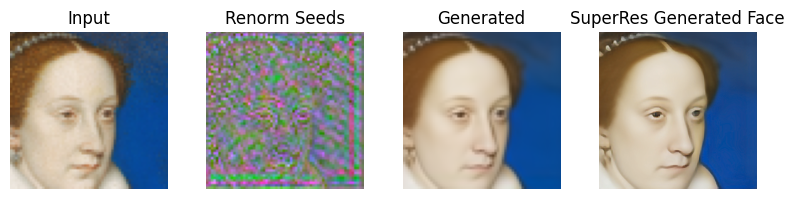


---- Replace face in the original image ----
1/1 [==============================] - 0s 23ms/step


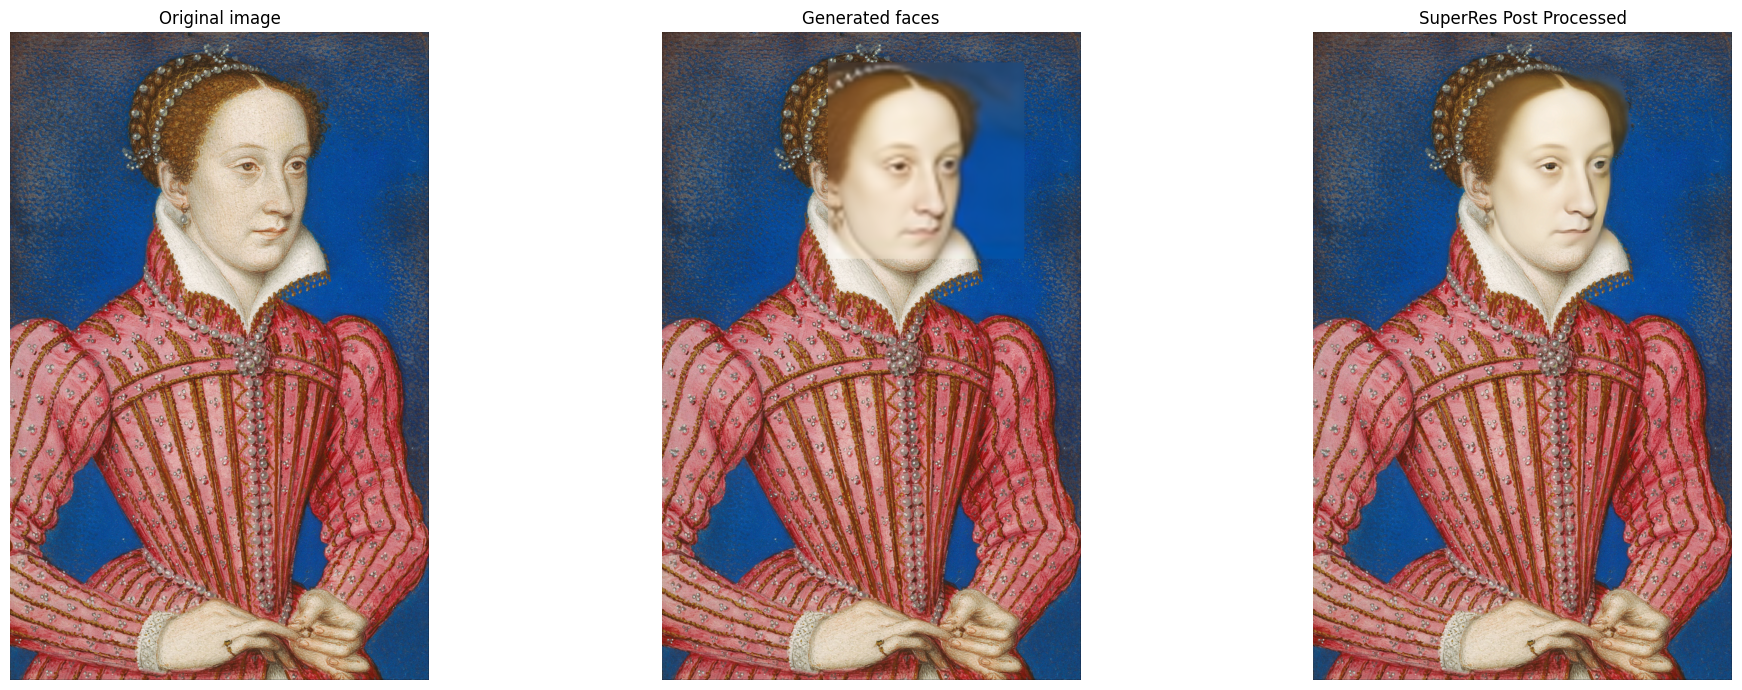

In [27]:
start_reification(image, gradient_descent_refinement = True, gradient_descent_epochs = 50)